In [450]:
import os

from sklearn.cluster import HDBSCAN
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import textwrap

from langchain_core.messages import SystemMessage
from langchain_core.prompts import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate
)

# Import Azure OpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureChatOpenAI



from dotenv import load_dotenv

from collections import Counter

from reclaim_tiktok.transcriber.db_connector import DBConnector
from reclaim_tiktok.classifier.classifier import Classifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [481]:
result = load_dotenv()
print(result)  # This should print True if the file is loaded successfully
# load dot env from .env file
load_dotenv(override=True)

True


True

In [ ]:
# get env variables
os.environ.get("AZURE_OPENAI_API_KEY")

In [475]:
embeddings_client = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small-eastus",
    openai_api_version="2024-02-01",
)

llm_client = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_deployment="gpt-35-turbo-16k",
)

## Get data and embed

In [219]:
db_connector = DBConnector()

In [220]:
rows = db_connector.get_videos_with_german_transcription_with_core_message()

In [221]:
len(rows)

6857

In [ ]:
print(rows[0])

In [250]:

# we have a list of pyodbc.Row objects  - hence we need to access the columns by index
# idx=8 is description, idx=11 is suggested words, idx=14 is german transcript

docs_classifier = [
    str(row[8]) + "\n\n" + str(row[11]) + "\n\n" + str(row[14]) for row in rows
]


In [223]:
len(docs_classifier)

6857

In [224]:
type(docs_classifier[0])

str

In [225]:
len(rows)

6857

In [226]:
embeddedings_desc_hashtags_transcripts = []

In [235]:
len(embeddedings_desc_hashtags_transcripts)

2000

In [236]:
docs_classifier_ar = docs_classifier

In [241]:
docs_classifier_ar = docs_classifier_ar[1000:]
len(docs_classifier)

1000

In [239]:
len(embeddedings_desc_hashtags_transcripts)

2000

In [243]:
docs_classifier = docs_classifier_ar

In [244]:
# loop over chunks of the documents list for robustness and to avoid api errors.
import time

for i in range(0, len(docs_classifier), 500):
    print(i)
    embeddings = embeddings_client.embed_documents(docs_classifier[i : i + 500])
    embeddedings_desc_hashtags_transcripts.extend(embeddings)
    # sleep for 1 minute to avoid api rate limits
    time.sleep(65)


0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [245]:
len(embeddedings_desc_hashtags_transcripts)


6857

In [246]:
# convert to numpy array
embeddedings_desc_hashtags_transcripts = np.array(embeddedings_desc_hashtags_transcripts)

In [247]:
# add the video ids from row[0] to the array to be able to map embeddings to video ids
video_ids = [row[0] for row in rows]
video_ids=np.array(video_ids)
print("shape (video_ids)", video_ids.shape)
print("shape (embeddedings_desc_hashtags_transcripts)", embeddedings_desc_hashtags_transcripts.shape)

# stack the video ids and the embeddings to be able to map them later
embeddings_to_save = np.column_stack((video_ids, embeddedings_desc_hashtags_transcripts)) 
np.save("../../data/embeddings/video_string_desc_hashtags_transcripts.npy", embeddings_to_save)


#np.save(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed_classifier.npy", embeddings_classifier)
#embeddings_classifier=np.load("../../data/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed_classifier.npy")

shape (video_ids) (6857,)
shape (embeddedings_desc_hashtags_transcripts) (6857, 1536)


In [248]:
embeddedings_desc_hashtags_transcripts.shape

(6857, 1536)

## Clean the data

Take only those classified right

In [251]:
right_classifier = Classifier(classifier_path="../../data/classifier/")
result= right_classifier.right_wing_classifier_f_embeddings(docs_classifier, embeddedings_desc_hashtags_transcripts, embeddings_client)
condition=result=="right"
# print number of True in the condition array
print(np.sum(condition))

6373


In [252]:

#df_clean=df[:][condition]
# now only keep rows where the classifier is right but not on df but in the original rows (list of pyodbc.Row objects)
rows_clean=[row for row, cond in zip(rows, condition) if cond]
len(rows_clean)
 

6373

Filter out the videos with the same text/audio 

In [253]:
transcripts_clean = [
    str(row[14]) for row in rows_clean
]

In [ ]:
transcripts_clean

In [255]:
embeddings_transcripts_clean = []

In [256]:
#embeddings_transcripts_clean = embeddings_client.embed_documents(np.array(transcripts_clean))
# make in chunks to avoid api errors
for i in range(0, len(transcripts_clean), 500):
    print(i)
    embeddings = embeddings_client.embed_documents(transcripts_clean[i : i + 500])
    embeddings_transcripts_clean.extend(embeddings)
    # sleep for 1 minute to avoid api rate limits
    time.sleep(65)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [257]:
len(embeddings_transcripts_clean)

6373

In [258]:
# Calculate cosine similarity between embeddings
similarities = cosine_similarity(embeddings_transcripts_clean)

# Keep track of videos to remove
videos_to_remove = set()

# Iterate through the upper triangular part of the similarity matrix
all_similar=[]
for i in range(len(similarities)):
    similar_videos = np.where((similarities[i] > 0.95))[0]
    if len(similar_videos) > 1:
        all_similar.append(list(similar_videos))
        # If there are similar videos, keep the one with the smallest index
        keep_video = min(similar_videos)
        videos_to_remove.update(set(similar_videos) - {keep_video})

In [260]:
len(videos_to_remove)

488

In [261]:
# save all video ids which need to be extracted from the original rows_clean list which are similar videos to a .csv file
video_ids_clean = [row[0] for row in rows_clean]
video_ids_all_similiar = [video_ids_clean[i] for i in videos_to_remove]
df = pd.DataFrame(video_ids_all_similiar, columns=["video_id"])
df.to_csv("../../data/clustering/similar_videos.csv", index=False)

Remove videos from rows_clean and embeddings_transcripts_clean

In [262]:
# remove the similar videos from the rows_clean list
rows_clean = [row for i, row in enumerate(rows_clean) if i not in videos_to_remove]

# remove the similar video emebedding from embeddings_transcripts_clean
embeddings_transcripts_clean = np.delete(embeddings_transcripts_clean, list(videos_to_remove), axis=0)

Display three videos which are most popular

In [263]:
rows[0][7]

598112

### Display

In [96]:
def merge_lists(lists):
    result = []
    for l in lists:
        new_set = set(l)
        found = False
        for i in range(len(result)):
            if new_set & result[i]:
                result[i] |= new_set
                found = True
                break
        if not found:
            result.append(new_set)
    return [list(s) for s in result]

all_similar_unique_entries = sorted([list(entry) for entry in all_similar])

unique_entries_merged=merge_lists(all_similar_unique_entries)
transcript_list=[np.array(rows_clean[14])[li_sim[0]] for li_sim in unique_entries_merged]
playcount_list=[ np.array(rows_clean[7])[li_sim] for li_sim in unique_entries_merged]
playcount_list_sum=[ sum(np.array(rows_clean[7])[li_sim]) for li_sim in unique_entries_merged]
most_popular_vid=[np.array(rows_clean[0])[li_sim] for li_sim in unique_entries_merged]

for ncount in range(1,4):
    most_popular_narr=np.argsort(playcount_list_sum)[-ncount]
    most_popular_video=np.argmax(playcount_list[most_popular_narr])
    print(str(ncount) +". popular viral audio")
    print(transcript_list[most_popular_narr])
    print(str(playcount_list_sum[most_popular_narr]) +" views")
    print("Example video "+ str(most_popular_vid[most_popular_narr][most_popular_video]) + " with a reach of " + str(playcount_list[most_popular_narr][most_popular_video]))
    print("\n")

IndexError: index 53 is out of bounds for axis 0 with size 20

## Get core messages for classified Videos from db

Create a new df with every line for unique core message

In [566]:
# load rows into dataframe with columns video_id [0], core_message [-1]
df_clean_double = pd.DataFrame(columns=["video_id", "core_message"])

In [567]:
df_clean_double["video_id"] = [row[0] for row in rows_clean]
df_clean_double["core_message"] = [row[-1] for row in rows_clean]
df_clean_double.head()
#len(df_clean_double)

,video_id,core_message
0,7004454022123932933,doch ich kann Ihnen sagen Burkas Kopftuchmädch...
1,7005858788343319813,Mach so bisschen Übergang deine Haare kürzer d...
2,7010413677136350469,Überbietungswettbewerb der Bundesländer bei C...
3,7013744740579511558,wir können gerne jetzt wieder den Ton anmachen...
4,7040421798785125638,Kritik an ungeimpftem Personal in der Pflege;...


In [568]:
# get empty core messages
empty_core_messages = df_clean_double[df_clean_double["core_message"] == ""]    
len(empty_core_messages)

0

In [ ]:
# filter for core messages which are longer than 800 characters
df_clean_double_long = df_clean_double[df_clean_double["core_message"].apply(len) > 800]
print(len(df_clean_double_long))
#print len of core messages
for i in range(0, len(df_clean_double_long)):
    print(len(df_clean_double_long["core_message"].iloc[i]))
    print(df_clean_double_long["core_message"].iloc[i])

In [569]:

# Remove unwanted values from core_message and split by ';'
df_clean_double['core_message'] = df_clean_double['core_message'].str.split(';')

# Explode the core_message column to create a new DataFrame df_cm
df_cm= df_clean_double.explode('core_message')

# remove empty core messages
# Reset index to ensure consecutive integers are used
df_cm.reset_index(drop=True, inplace=True)

In [570]:
df_cm.head()

,video_id,core_message
0,7004454022123932933,doch ich kann Ihnen sagen Burkas Kopftuchmädch...
1,7005858788343319813,Mach so bisschen Übergang deine Haare kürzer d...
2,7010413677136350469,Überbietungswettbewerb der Bundesländer bei C...
3,7010413677136350469,Kritik an der 2G-Regelung in Baden-Württemberg
4,7010413677136350469,Staatliche Maßnahmen verstoßen gegen das Grun...


In [573]:
# get empty core messages
empty_core_messages_i = df_cm[df_cm["core_message"] == ""]
empty_core_messages_ii = df_cm[df_cm["core_message"] == " "]
print(len(empty_core_messages_i) + len(empty_core_messages_ii))

1050


In [574]:
len(df_cm)

14176

In [575]:
# remove empty core messages
df_cm = df_cm[df_cm["core_message"] != ""]
df_cm = df_cm[df_cm["core_message"] != " "]
df_cm.reset_index(drop=True, inplace=True)
df_cm.head()

,video_id,core_message
0,7004454022123932933,doch ich kann Ihnen sagen Burkas Kopftuchmädch...
1,7005858788343319813,Mach so bisschen Übergang deine Haare kürzer d...
2,7010413677136350469,Überbietungswettbewerb der Bundesländer bei C...
3,7010413677136350469,Kritik an der 2G-Regelung in Baden-Württemberg
4,7010413677136350469,Staatliche Maßnahmen verstoßen gegen das Grun...


In [576]:
len(df_cm)

13126

Generate embeddings per core message

In [577]:
# chunk the core messages to avoid api errors
embeddings_cm = embeddings_client.embed_documents(df_cm["core_message"])
embeddings_cm=np.array(embeddings_cm)

In [578]:
embeddings_cm.shape

(13126, 1536)

In [579]:
# add embeddings to the dataframe
df_cm["embeddings"]=list(embeddings_cm)

# save the dataframe to a .csv file
df_cm.to_csv("../../data/embeddings/core_message_embeddings.csv", index=False)

In [580]:
#print averare number of words of core messages
print(np.mean([len(text.split()) for text in df_cm["core_message"]]))

18.637437147645894


# Data clustering

## Kmeans

Calculate the optimal amount of cluster

In [305]:
max_number_of_clusters = 300

In [300]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(2, max_number_of_clusters):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(embeddings_cm)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

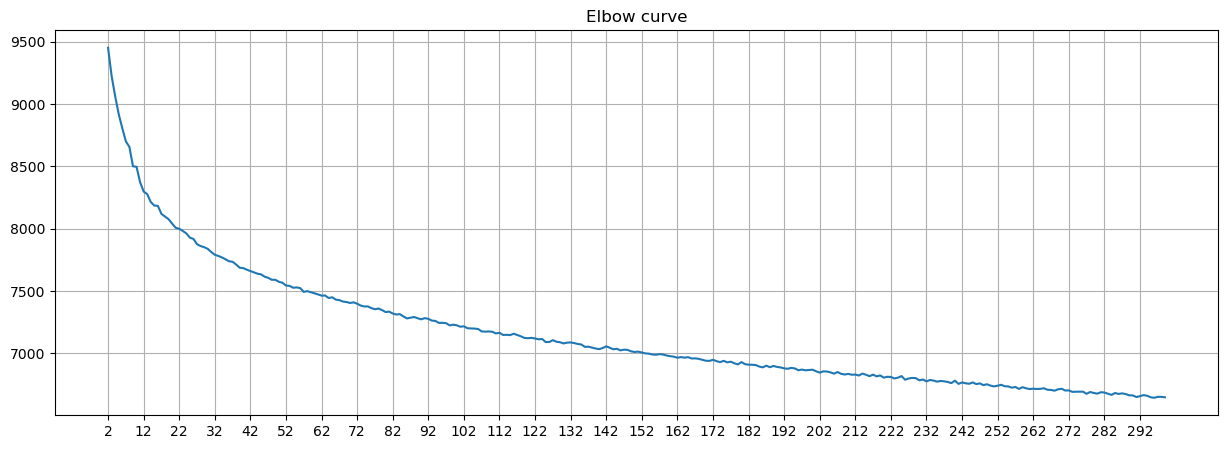

In [307]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_number_of_clusters), distorsions)
plt.grid(True)
# only plot each 10th tick on the x-axis
plt.xticks(np.arange(2, max_number_of_clusters, 10)) 
plt.title('Elbow curve')
#you should pick the elbow of the curve for the optimal number of clusters

In [644]:
matrix = np.vstack(embeddings_cm)
matrix.shape

(13126, 1536)

In [637]:
kmeans = KMeans(n_clusters=140, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

In [ ]:
Counter(labels)

Map to unexisting ids in db

In [641]:
# drop cluster column
#df_cm.drop(columns=["cluster"], inplace=True, errors="ignore")

In [642]:
df_cm.head()

,video_id,core_message,embeddings,topic_title
0,7004454022123932933,doch ich kann Ihnen sagen Burkas Kopftuchmädch...,"[-0.024773955938654356, 0.030911649386536056, ...","Fokussierung auf nationale Identität, Souverän..."
1,7005858788343319813,Mach so bisschen Übergang deine Haare kürzer d...,"[0.02599616419900313, -0.017954683998939024, 0...","Grüne Partei wird durchgehend als inkompetent,..."
2,7010413677136350469,Überbietungswettbewerb der Bundesländer bei C...,"[-0.028749052452035188, -0.03657082606005345, ...",Steuergeldverschwendung und finanzielle Fehlen...
3,7010413677136350469,Kritik an der 2G-Regelung in Baden-Württemberg,"[-0.02502290165787953, 0.022745912952092634, -...","Kritik an der deutschen Regierungspolitik, mit..."
4,7010413677136350469,Staatliche Maßnahmen verstoßen gegen das Grun...,"[-0.03675452556435304, 0.03118101453676938, 0....",Staatliche Überwachung und Einschränkung der G...


In [639]:
# we need to make sure the cluster_ids are unique and not existent in the db
existing_cluster_ids = db_connector.get_existing_cluster_ids()
# convert the list of pyodbcd.row to a set
exisiting_cluster_ids = set([row[0] for row in existing_cluster_ids])

# get unique number of labels
unique_labels = np.unique(labels)

# create a mapping from old cluster ids to new cluster ids
cluster_id_mapping = {}
for i, label in enumerate(unique_labels):
    while label in exisiting_cluster_ids:
        label += 1
    cluster_id_mapping[i] = label
    # add the new cluster id to the set
    exisiting_cluster_ids.add(label)

In [ ]:
# create a new column in the dataframe with the new cluster ids
df_cm["cluster"] = [cluster_id_mapping[label] for label in labels]
df_cm.head()

In [586]:
# df with unique cluster ids
df_unique_clusters = df_cm.drop_duplicates(subset=["cluster"])
len(df_unique_clusters)
#drop the embeddings column, the core_message column and the video_id column
df_unique_clusters.drop(columns=["embeddings", "core_message", "video_id"], inplace=True)
df_unique_clusters["topic_title"] = ""
df_unique_clusters.head()


,cluster,topic_title
0,117,
1,121,
2,115,
3,130,
4,134,


In [587]:
len(df_cm)

13126

In [588]:
# only keep one pair of video_id and cluster if duplicated
df_cm= df_cm.drop_duplicates(subset=["video_id", "cluster"])
len(df_cm)

10901

In [589]:
# Group df_cm by "video_id" and aggregate the clusters with ";"
cluster_groups = df_cm.groupby('video_id')['cluster'].agg(lambda x: ';'.join(map(str, x))).reset_index()

# Merge the aggregated clusters back into df_clean_double based on "video_id"
df_clean_double = pd.merge(df_clean_double, cluster_groups, on='video_id', how='left')


In [590]:
df_clean_double.head()

,video_id,core_message,cluster
0,7004454022123932933,[doch ich kann Ihnen sagen Burkas Kopftuchmädc...,117
1,7005858788343319813,[Mach so bisschen Übergang deine Haare kürzer ...,121
2,7010413677136350469,[ Überbietungswettbewerb der Bundesländer bei ...,115;130;134
3,7013744740579511558,[wir können gerne jetzt wieder den Ton anmache...,126
4,7040421798785125638,[ Kritik an ungeimpftem Personal in der Pflege...,113;143;123


In [320]:
import pyodbc

In [591]:

driver = os.environ["DB_DRIVER"]
server = os.environ["DB_SERVER"]
database = os.environ["DB_DATABASE"]
username = os.environ["DB_USERNAME"]
password = os.environ["DB_PASSWORD"]
connection_str = f"Driver={driver};Server={server},1433;Database={database};Uid={username};Pwd={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"


In [592]:
import datetime


def add_clusters_to_db(clusters_with_title, connection_str):
    """
    Add clusters to the SQL database.
    Args:
        clusters_with_title: DataFrame with cluster_number and topic_title.
        connection_str: Connection string to the SQL database.
    """
    
    with pyodbc.connect(connection_str) as cnxn:
        cursor = cnxn.cursor()
        
        # Get all unique cluster ids already in the SQL database
        cursor.execute("SELECT id FROM dbo.Clusters")
        existing_cluster_ids = {row[0] for row in cursor.fetchall()}
        
        # Extract unique cluster ids and their descriptions from the DataFrame
        clusters_to_add = clusters_with_title[['cluster', 'topic_title']].drop_duplicates()
        
        # Determine which cluster ids need to be added
        clusters_to_add = clusters_to_add[~clusters_to_add['cluster'].isin(existing_cluster_ids)]
        
        print(f"Adding {len(clusters_to_add)} new clusters to the database")

        # Add new cluster ids to the Clusters table
        for _, row in clusters_to_add.iterrows():
            cluster_id = int(row['cluster'])
            description = str(row['topic_title'])
            cursor.execute("INSERT INTO dbo.Clusters (id, description, timestamp) VALUES (?, ?, ?)", cluster_id, description, datetime.datetime.now())
        
        # Commit the new clusters
        cnxn.commit()
        

In [593]:
add_clusters_to_db(df_unique_clusters, connection_str)

Adding 32 new clusters to the database


In [594]:

def add_cluster_video_links_to_db(cluster_assignments, connection_str):
    """
    Add cluster video links to the SQL database.
    Args:
        cluster_assignments: DataFrame with video_id and cluster data.
        connection_str: Connection string to the SQL database.
    """
    
    with pyodbc.connect(connection_str) as cnxn:
        cursor = cnxn.cursor()
        
        # Get all existing video_id and cluster_id pairs from the database
        cursor.execute("SELECT video_id, cluster_id FROM dbo.VideoClusters")
        existing_pairs = set((row.video_id, row.cluster_id) for row in cursor.fetchall())
        
        # Collect all new rows to be inserted in a list
        rows_to_insert = []
        
        for _, row in cluster_assignments.iterrows():
            video_id = int(row['video_id'])
            clusters = map(int, row['cluster'].split(';'))
            
            for cluster_id in clusters:
                if (video_id, cluster_id) not in existing_pairs:
                    rows_to_insert.append((cluster_id, video_id))
        print(len(rows_to_insert))
        # Insert all rows in one batch
        if rows_to_insert:
            cursor.executemany("INSERT INTO dbo.VideoClusters (cluster_id, video_id) VALUES (?, ?)", rows_to_insert)
        
        # Commit the relationships
        cnxn.commit()
        print("Clusters and relationships added to database successfully")

# Example usage
# Assuming `cluster_assignments` is a DataFrame with the required structure and `connection_str` is your database connection string
# add_cluster_video_links_to_db(cluster_assignments, connection_str)


In [647]:
add_cluster_video_links_to_db(df_clean_double[["video_id", "cluster"]], connection_str)

10901
Clusters and relationships added to database successfully


In [646]:
len(df_clean_double)

5885

In [526]:
# get duplicates VideoClusters if they have cluster id and video id in common
with pyodbc.connect(connection_str) as cnxn:
    cursor = cnxn.cursor()
    cursor.execute("SELECT cluster_id, video_id, COUNT(*) FROM dbo.VideoClusters GROUP BY cluster_id, video_id HAVING COUNT(*) > 1")
    duplicates = cursor.fetchall()
    #remove duplicates
    # for cluster_id, video_id, count in duplicates:
    #     cursor.execute("DELETE FROM dbo.VideoClusters WHERE cluster_id = ? AND video_id = ?", cluster_id, video_id)

In [527]:
len(duplicates)

0

## Switch to gpt-4

### Need to change endpoint since deployed on different region

In [595]:
# change env variable 
load_dotenv(override=True)

True

In [596]:
# embeddings_client = AzureOpenAIEmbeddings(
#     azure_deployment="text-embedding-3-small-eastus",
#     openai_api_version="2024-02-01",
# )

# llm_client = AzureChatOpenAI(
#     openai_api_version="2024-02-01",
#     azure_deployment="gpt-35-turbo-16k",
# )

llm_client = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-4-turbo-128k",
)

### Cluster naming with GPT

In [627]:
#Der Titel sollte das gemeinsame Narrativ bestmöglichst beschreiben. Beispiele sind:  Positionierung gegen Einwanderung, Forderung die kulturelle Identität zu schützen oder aufzubauen, Hinterfragen des Vorgehens der EU, nationale Souveränität betonen, Forderung nach einer harten Hand gegen Kriminalität und Terrorismus, Hetzerischer Angriff und Kritik an Grünen ohne konstruktive Gegenvorschläge.
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "Du bist ein Experte im Schreiben. Du hilfst mir, einen gemeinsames Narrativ für mehrere ähnliche TikTok-Beiträge zu schreiben. Die Videos stammen aus einem Datensatz mit rechten bis rechtsextremen Inhalten, diesen wollen wir analaysieren. Analysiere welche Themen besonders aufgegriffen werden und finde eine sehr kurze Beschreibung, die aber nicht zu generisch sondern konktret sein sollte."
            )
        ),
        HumanMessagePromptTemplate.from_template("Schreibe anhand der folgenden deutschen Transkripte und Beschreibungen von Tiktok-Videos eine und nur eine möglichst genaue und treffende analytische Beschreibung des Narrativs der Videos. Die Beschreibung sollte auf deutsch um die 20 Wörter sein (maximal 30). Sollte keine Übertitel, keine Anführungsstriche und vermeide unkonkrete Floskeln wie 'Analyse der', 'Narrativ der' und 'Kritik an'. Nachfolgend: \n\nPOSTS:{posts}\n\n\n\n\n\n Erinnere dich nochmal an deine Aufgabenstellung. \n\n  Narrativ Beschreibung:"),
    ]
)

In [628]:
#try out with stopwords

german_stop_words=open("../../data/clustering/german_stopwords_full.txt").read().split()[53:]

In [ ]:
for c in sorted(df_cm.cluster.unique()):
    try:
        print(c)
        # Generate posts string
        posts_str = "\n".join(
            f"{post['core_message']}\n" #\n{post['suggested_words']}{post['video_description']}\n
            for post in df_cm.query(f"cluster == {c}").to_dict(orient="records")
        )
        # posts_str = ' '.join([word for word in posts_str.split() if word not in ([])])
        
        if len(posts_str) > 128000:
            posts_str = ' '.join([word for word in posts_str.split() if word not in (german_stop_words)])
            

        # limit str to maximum token length of model 16384
        print(len(posts_str))
        posts_str = posts_str[:127000]
        posts_str = posts_str.replace("Kanacke", "Ausländer")
        # Create prompt
        #prompt = get_prompt(articles_str)
        prompt = chat_template.format_messages(posts=posts_str)
        # Invoke the model and pass the generated prompt
        result = llm_client.invoke(prompt)
        #print(result)

        # Assuming result extraction based on your specific response structure
        df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
    except Exception as e:
        print("content warning triggered for cluster "+str(c))
        print(e)

        # chunk the posts_str to avoid api errors
        for i in range(0, len(posts_str), int(len(posts_str)/5)):
            try:
                print("chunk:", i)
                prompt = chat_template.format_messages(posts=posts_str[i : i + int(len(posts_str)/5)])
                # Invoke the model and pass the generated prompt
                result = llm_client.invoke(prompt)
                # Assuming result extraction based on your specific response structure
                df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
            except Exception as e:
                print("content warning triggered for cluster "+str(c))
                print(prompt)
                #remove problematic chuck from string
                posts_str=posts_str[:i]+posts_str[i + int(len(posts_str)/5):]
                print("chunk removed")
                print("length of the shorten posts_str", len(posts_str))
                break
            
        # try with the remaining string
        try:
            print("try with the remaining string")
            prompt = chat_template.format_messages(posts=posts_str)
            # Invoke the model and pass the generated prompt
            result = llm_client.invoke(prompt)
            # Assuming result extraction based on your specific response structure
            df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content

            print("finally successful for cluster "+str(c))
        except Exception as e:
            print("content warning triggered again for chunked string")
            print(e)

        # posts_str = "\n".join(
        #     f"{post['core_message']}\n" #\n{post['suggested_words']}{post['video_description']}\n
        #     for post in df_cm.query(f"cluster == {c}").to_dict(orient="records")
        # )
        # #posts_str = ' '.join([word for word in posts_str.split() if word not in (german_stop_words)])

        # # limit str to maximum token length of model 16384
        # posts_str = posts_str[:16384]
        # # Create prompt
        # #prompt = get_prompt(articles_str)
        # prompt = chat_template.format_messages(posts=posts_str)
        # # Invoke the model and pass the generated prompt
        # result = llm_client.invoke(prompt)
        # # Assuming result extraction based on your specific response structure
        # df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
        continue

In [631]:
#   get unique topic titles
df_unique_clusters_test = df_cm.drop_duplicates(subset=["cluster"])
df_unique_clusters_test
# get number of words of topic titles
print([len(title.split()) for title in df_unique_clusters_test["topic_title"]])
#print([len(title) for title in df_unique_clusters_test["topic_title"]])

[17, 12, 10, 16, 16, 15, 14, 12, 15, 16, 17, 14, 16, 13, 15, 14, 26, 21, 12, 17, 14, 20, 15, 33, 21, 23, 14, 16, 16, 16, 18, 18]


In [636]:
len(df_unique_clusters_test)

32

In [633]:
# print cluster_id and topic_title
for i in range(0, len(df_unique_clusters_test)):
    print(int(df_unique_clusters_test["cluster"].iloc[i]), str(df_unique_clusters_test["topic_title"].iloc[i]))


117 Fokussierung auf nationale Identität, Souveränität und Kritik an Regierungspolitik, Migration sowie wirtschaftlicher und sozialer Verfall in Deutschland.
121 Grüne Partei wird durchgehend als inkompetent, ideologisch verblendet und gesellschaftlich schädlich dargestellt.
115 Steuergeldverschwendung und finanzielle Fehlentscheidungen der Regierung belasten deutsche Bürger zunehmend.
130 Kritik an der deutschen Regierungspolitik, mit Schwerpunkt auf Corona-Maßnahmen, Umwelt-, Energie- und Migrationspolitik sowie der Ampelkoalition.
134 Staatliche Überwachung und Einschränkung der Grundrechte im Namen des Verfassungsschutzes, Missbrauch von Behördenmacht gegen politische Opposition.
126 Videos propagieren nationalistische und xenophobe Einstellungen, verherrlichen traditionelle Rollenbilder und lehnen moderne soziale Konzepte ab.
113 Verbreitung von Misstrauen gegenüber Impfungen, Politik und Medien, verbunden mit Verschwörungstheorien und politischer Manipulation.
143 Verstärkung des

### Add cluster descriptions to db

In [634]:
# print cluster_id and topic_title
for i in range(0, len(df_unique_clusters_test)):
    db_connector.update_cluster_description(int(df_unique_clusters_test["cluster"].iloc[i]), str(df_unique_clusters_test["topic_title"].iloc[i]))


Updated cluster 117 with description Fokussierung auf nationale Identität, Souveränität und Kritik an Regierungspolitik, Migration sowie wirtschaftlicher und sozialer Verfall in Deutschland.
Updated cluster 121 with description Grüne Partei wird durchgehend als inkompetent, ideologisch verblendet und gesellschaftlich schädlich dargestellt.


Updated cluster 115 with description Steuergeldverschwendung und finanzielle Fehlentscheidungen der Regierung belasten deutsche Bürger zunehmend.
Updated cluster 130 with description Kritik an der deutschen Regierungspolitik, mit Schwerpunkt auf Corona-Maßnahmen, Umwelt-, Energie- und Migrationspolitik sowie der Ampelkoalition.
Updated cluster 134 with description Staatliche Überwachung und Einschränkung der Grundrechte im Namen des Verfassungsschutzes, Missbrauch von Behördenmacht gegen politische Opposition.
Updated cluster 126 with description Videos propagieren nationalistische und xenophobe Einstellungen, verherrlichen traditionelle Rollenbilder und lehnen moderne soziale Konzepte ab.
Updated cluster 113 with description Verbreitung von Misstrauen gegenüber Impfungen, Politik und Medien, verbunden mit Verschwörungstheorien und politischer Manipulation.
Updated cluster 143 with description Verstärkung des Fachkräftemangels durch Abwanderung qualifizierter Deutscher und Kritik an de

In [ ]:
new_df = df_cm.groupby('video_id').agg({
    'cluster': lambda x: ';'.join(str(v) for v in x),
    'core_message': lambda x: ';'.join(str(v) for v in x),
    'video_playcount': 'first',     # Retain the first play count
    'video_timestamp': 'first'      # Retain the first timestamp
}).reset_index()


# Display the new DataFrame
new_df.head()

In [ ]:
new_df=pd.read_csv(path_csv+"1405_data_with_clusters.csv")

In [ ]:
merged_df = pd.merge(new_df, df_clean[['video_id', 'english_transcript']], on='video_id', how='left')
merged_df = pd.merge(merged_df, df_clean[['video_id', 'german_transcript']], on='video_id', how='left')


In [ ]:
merged_df

,Unnamed: 0,video_id,cluster,core_message,video_playcount,video_timestamp,english_transcript,german_transcript
0,0,7005858788343319813,23,Mach so bisschen Übergang deine Haare kürzer d...,613338,1631178624,NaN,Mach so bisschen Übergang deine Haare kürzer d...
1,1,7040421798785125638,1;22;15,Kritik an ungeimpftem Personal in der Pflege;...,30603,1639225941,NaN,nötigerweise Menschen sterben weil Ungeimpfte ...
2,2,7052592640344329477,13,7 Millionen sozialgeldempfänger davon gut die ...,27175,1642059688,NaN,7 Millionen sozialgeldempfänger davon gut die ...
3,3,7069273153373097221,22;17;17,- Hohe Anzahl von Arztbesuchen aufgrund von Im...,235154,1645943422,NaN,und zu den Nebenwirkungen das äh Nebenwirkunge...
4,4,7080134745832557830,16;1;0,Unterschied zwischen Gesundheitspolitik und p...,7439,1648472331,NaN,sehr geehrte frau präsidentin kolleginnen und ...
...,...,...,...,...,...,...,...,...
2065,2065,7365836620957814049,16,Politiker werden angegriffen; Regierung ist bü...,20283,1714992492,recently are increasingly common Politician an...,in jüngster Zeit sind immer häufiger Politiker...
2066,2066,7365899292927741216,7,"Deutschland ist unsere Heimat, unser Land, uns...",8263,1715007082,"Germany is our home, our country, our nation ...","Deutschland ist unsere Heimat, unser Land, uns..."
2067,2067,7365925784864722209,3;3;3,- Definition des deutschen Staatsangehörigen i...,1323,1715013248,NaN,"ne, es geht um Artikel 1 äh, Absatz 1. Deutsch..."
2068,2068,7366492764877442336,23,sie wissen ja wofür Antifa steht oder nein dan...,38494,1715145281,you know what Antifa stands for or no then I'l...,sie wissen ja wofür Antifa steht oder nein dan...


In [ ]:
merged_df.to_csv(path_csv+"1405_data_with_clusters.csv")

In [ ]:
new_df.to_csv(path_csv+"1405_data_with_clusters.csv")
topic_title=[df_cm.query(f"cluster == {c}").topic_title.values[0] for c in sorted(df_cm.cluster.unique())]
df_topic_title=pd.DataFrame(topic_title, columns=["topic_title"])
df_topic_title["cluster_number"]=np.arange(24)
df_topic_title.to_csv(path_csv+"1405_data_topic_title.csv")

In [ ]:
df_cm.to_csv(path_csv+"df_cm.csv")
#df_cm=pd.read_csv(path_csv+"df_cm.csv")

In [ ]:
# find the most central datapoint # adjust this code for most cosine clim

# Loop over all clusters and find index of closest point to the cluster center and append to closest_pt_idx list.
closest_pt_idx = []
for iclust in range(kmeans.n_clusters):
    # get all points assigned to each cluster:
    cluster_pts = embeddings_cm[kmeans.labels_ == iclust]
    # get all indices of points assigned to this cluster:
    cluster_pts_indices = np.where(kmeans.labels_ == iclust)[0]

    cluster_cen = kmeans.cluster_centers_[iclust]
    min_idx = np.argmax([cosine_similarity([embeddings_cm[idx]], [cluster_cen])[0] for idx in cluster_pts_indices])
    
    # Testing:    
    #print('closest point to cluster center: ', cluster_pts[min_idx])
    #print('closest index of point to cluster center: ', cluster_pts_indices[min_idx])
    closest_pt_idx.append(cluster_pts_indices[min_idx])

In [ ]:
counter=Counter(labels)
count_arr = sorted([[key, value] for key, value in counter.items()])
#summed_reach=[sum(df_cm.query(f"cluster == {c}").video_playcount.values) for c in sorted(df_cm.cluster.unique())]
topic_title=[df_cm.query(f"cluster == {c}").topic_title.values[0] for c in sorted(df_cm.cluster.unique())]


# print cluster number and topic title
for i in range(0, len(count_arr)):
    print(count_arr[i][0])
    print(count_arr[i][1])
    print(topic_title[i])
    print("\n")

In [ ]:
for c in sorted(df_cm.cluster.unique()):
        
    with pd.option_context("display.max_colwidth", None):
        #print cluster id
        print(f"Cluster {c} "+ str(count_arr[c][1]))
        print(df_cm.query(f"cluster == {c}").topic_title.values[0])
        print(sum(df_cm.query(f"cluster == {c}").video_playcount.values))
        print(np.array(df_cm["video_id"])[closest_pt_idx[c]])
       #display(df.query(f"cluster == {c}").drop(columns=["topic_title"]).head())

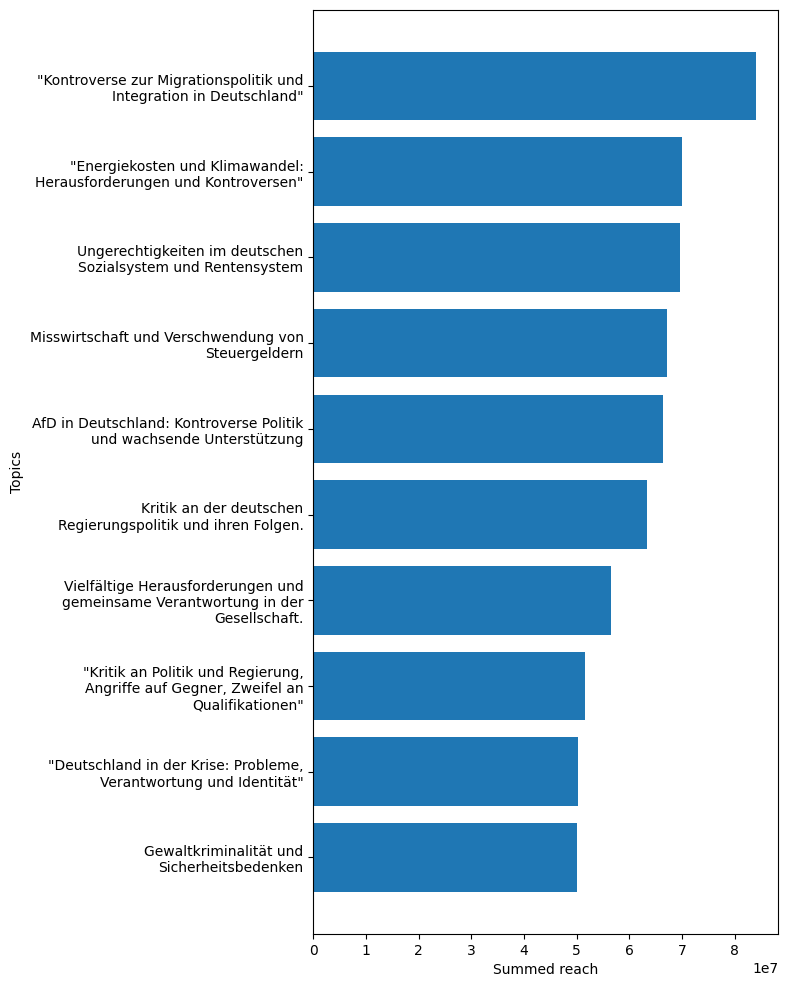

In [ ]:
plt.figure(figsize=(6, 12))  # Adjust figure size as needed
wrapped_titles = [textwrap.fill(title, width=40) for title in topic_title]
sorted_data = sorted(zip(wrapped_titles, summed_reach), key=lambda x: x[1], reverse=True)
sorted_titles, sorted_reach = zip(*sorted_data)

plt.barh(sorted_titles[:10],sorted_reach[:10])  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Summed reach')
plt.ylabel('Topics')
#plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

In [ ]:


mean_reach=[]
for c in range(24):
    cluster_pts = embeddings_cm[kmeans.labels_ == c]
    X=embeddings_cm[df_cm.query(f"cluster == {c}").index]
    reach=df_cm.query(f"cluster == {c}").video_playcount
    cluster_cen = kmeans.cluster_centers_[c]
    cluster_pts_indices = df_cm.query(f"cluster == {c}").index
    body = [1- cosine_similarity([embeddings_cm[idx]], [cluster_cen])[0,0] for idx in cluster_pts_indices]
    
    mean_reach.append(np.mean(reach[np.array(body)<0.6]))
    #print("Average Reach for cluster "+ str(c)+ ":", mean_reach)

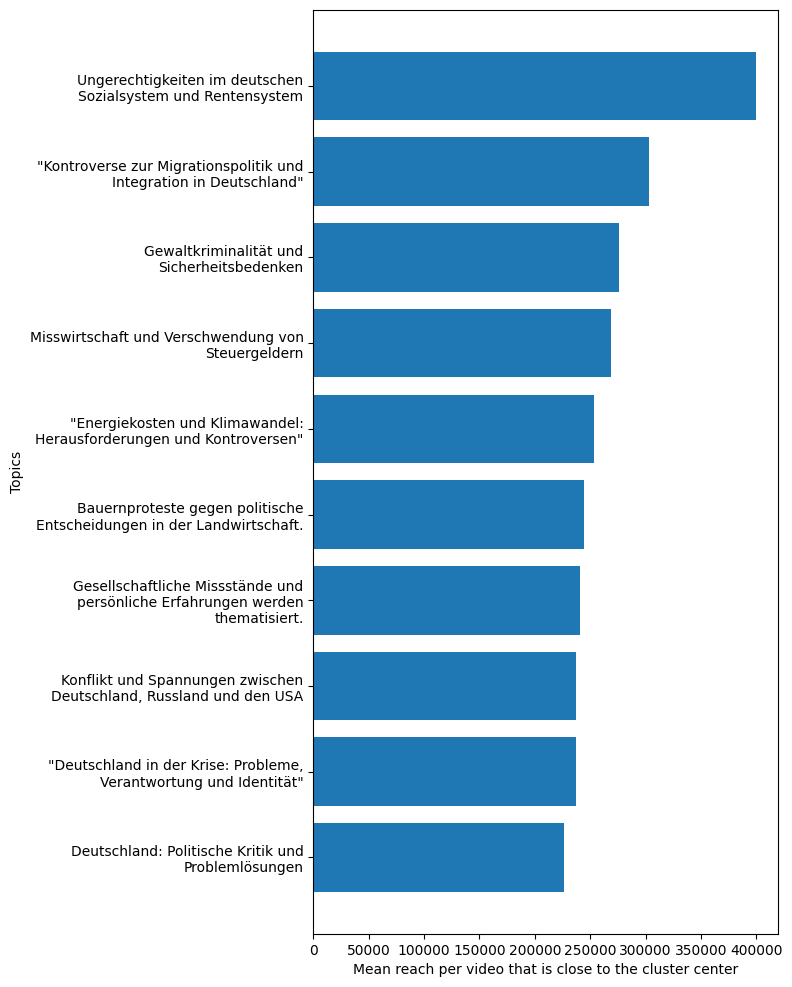

In [ ]:
#display most viral topics 

plt.figure(figsize=(6, 12))  # Adjust figure size as needed
wrapped_titles = [textwrap.fill(title, width=40) for title in topic_title]
sorted_data = sorted(zip(wrapped_titles, mean_reach), key=lambda x: x[1], reverse=True)
sorted_titles, sorted_reach = zip(*sorted_data)

plt.barh(sorted_titles[:10],sorted_reach[:10])

# Adding labels and title
plt.xlabel('Mean reach per video that is close to the cluster center')
plt.ylabel('Topics')
#plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()